In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

# Dataset, binary data and continuous data

In [2]:
def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bits.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')

def packnbits(arr, axis=-1):
    '''pack bits to numbers.'''
    nd = np.ndim(arr)
    nbit = np.shape(arr)[axis]
    if axis < 0:
        axis = nd + axis
    return (arr * (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1))\
           ).sum(axis=axis, keepdims=True).astype('int')

In [3]:
def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0\
           )|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

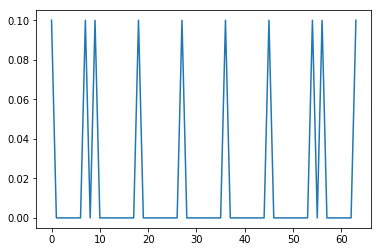

In [17]:
geometry = (2,3)
pl2 = barstripe_pdf(geometry)
plt.plot(pl2)
plt.show()

# Build Circuits
## Building Blocks

In [19]:
######  Pauli Matrices  ########
I2 = sps.eye(2).tocsr()
sx = sps.csr_matrix([[0,1],[1,0.]])
sy = sps.csr_matrix([[0,-1j],[1j,0.]])
sz = sps.csr_matrix([[1,0],[0,-1.]])

p0 = (sz + I2) / 2
p1 = (-sz + I2) / 2

# single bit rotation matrices
def _ri(si, theta):
    return np.cos(theta/2.)*I2 - 1j*np.sin(theta/2.)*si

def rot(t1, t2, t3):
    '''
    a general rotation gate rz(t3)rx(r2)rz(t1).

    Args:
        t1, t2, t3 (float): three angles.

    Returns:
        2x2 csr_matrix: rotation matrix.
    '''
    return _ri(sz, t3).dot(_ri(sx, t2)).dot(_ri(sz, t1))

# multiple bit construction
def CNOT(ibit, jbit, n):
    '''
    CNOT gate
    
    Args:
        ibit (int): control bit.
        jbit (int): controled bit.
        n (int): total number of qubits.
    '''
    res = _([p0, I2], [ibit, jbit], n)
    res = res + _([p1, sx], [ibit, jbit], n)
    return res

def _(ops, locs, n):
    '''
    Compile operators into specific Hilbert space.

    notice the big end are high loc bits!

    Args:
        ops (list): list of single bit operators.
        locs (list): list of positions.
        n (int): total number of bits.

    Returns:
        csr_matrix: resulting matrix.
    '''
    if np.ndim(locs) == 0:
        locs = [locs]
    if not isinstance(ops, (list, tuple)):
        ops = [ops]
    locs = np.asarray(locs)
    locs = n - locs
    order = np.argsort(locs)
    locs = np.concatenate([[0], locs[order], [n + 1]])
    return _wrap_identity([ops[i] for i in order], np.diff(locs) - 1)


def _wrap_identity(data_list, num_bit_list):
    if len(num_bit_list) != len(data_list) + 1:
        raise Exception()

    res = sps.eye(2**num_bit_list[0])
    for data, nbit in zip(data_list, num_bit_list[1:]):
        res = sps.kron(res, data)
        res = sps.kron(res, sps.eye(2**nbit, dtype='complex128'))
    return res


def initial_wf(num_bit):
    '''initial wave function |00...0>.'''
    wf = np.zeros(2**num_bit, dtype='complex128')
    wf[0] = 1.
    return wf

In [20]:
class ArbituaryRotation(object):
    def __init__(self, num_bit):
        self.num_bit = num_bit
        self.mask = np.array([True] * (3*num_bit), dtype='bool')

    @property
    def num_param(self):
        return self.mask.sum()

    def tocsr(self, theta_list):
        '''transform this block to csr_matrix.'''
        theta_list_ = np.zeros(3*self.num_bit)
        theta_list_[self.mask] = theta_list
        rots = [rot(*ths) for ths in theta_list_.reshape([self.num_bit,3])]
        res = [_([r], [i], self.num_bit) for i,r in enumerate(rots)]
        return res

class CNOTEntangler(object):
    def __init__(self, num_bit, pairs):
        self.num_bit = num_bit
        self.pairs = pairs

    @property
    def num_param(self):
        return 0

    def tocsr(self, theta_list):
        '''transform this block to csr_matrix.'''
        i, j = self.pairs[0]
        res = CNOT(i, j, self.num_bit)
        for i, j in self.pairs[1:]:
            res = CNOT(i,j,self.num_bit).dot(res)
        res.eliminate_zeros()
        return [res]

In [21]:
class BlockQueue(list):
    '''
    Block Queue that keep track of theta_list changing history, for fast update.
    '''
    def __init__(self, *args):
        list.__init__(self, *args)
        self.theta_last = None
        self.memo = None

    def __call__(self, qureg, theta_list):
        # cache? if theta_list change <= 1 parameters, then don't touch memory.
        remember = self.theta_last is None or (abs(self.theta_last-theta_list)>1e-12).sum() > 1

        mats = []
        theta_last = self.theta_last
        if remember:
            self.theta_last = theta_list.copy()

        qureg_ = qureg
        for iblock, block in enumerate(self):
            # generate or use a block matrix
            num_param = block.num_param
            theta_i, theta_list = np.split(theta_list, [num_param])
            if theta_last is not None:
                theta_o, theta_last = np.split(theta_last, [num_param])
            if self.memo is not None and (num_param==0 or np.abs(theta_i-theta_o).max()<1e-12):
                # use data cached in memory
                mat = self.memo[iblock]
            else:
                if self.memo is not None and not remember:
                    # update the changed gate, but not touching memory.
                    mat = _rot_tocsr_update1(block, self.memo[iblock], theta_o, theta_i)
                else:
                    # regenerate one
                    mat = block.tocsr(theta_i)
            for mat_i in mat:
                qureg_ = mat_i.dot(qureg_)
            mats.append(mat)

        if remember:
            # cache data
            self.memo = mats
        # update register
        qureg[...] = qureg_
        np.testing.assert_(len(theta_list)==0)
        
    @property
    def num_bit(self):
        return self[0].num_bit

    @property
    def num_param(self):
        return sum([b.num_param for b in self])

def _rot_tocsr_update1(layer, old, theta_old, theta_new):
    '''
    rotation layer csr_matrix update method.
    
    Args:
        layer (ArbituaryRotation): rotatio layer.
        old (csr_matrix): old matrices.
        theta_old (1darray): old parameters.
        theta_new (1darray): new parameters.

    Returns:
        csr_matrix: new rotation matrices after the theta changed.
    '''
    idiff_param = np.where(abs(theta_old-theta_new)>1e-12)[0].item()
    idiff = np.where(layer.mask)[0][idiff_param]

    # get rotation parameters
    isite = idiff//3
    theta_list_ = np.zeros(3*layer.num_bit)
    theta_list_[layer.mask] = theta_new
    
    new = old[:]
    new[isite] = _(rot(*theta_list_[isite*3:isite*3+3]), isite, layer.num_bit)
    return new
    
def get_demo_circuit(num_bit, depth, pairs):
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbituaryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))

    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [22]:
def get_nn_pairs(geometry):
    '''define pairs that cnot gates will apply.'''
    num_bit = np.prod(geometry)
    if len(geometry) == 2:
        nrow, ncol = geometry
        res = []
        for ij in range(num_bit):
            i, j = ij // ncol, ij % ncol
            res.extend([(ij, i_ * ncol + j_)
                        for i_, j_ in [((i + 1) % nrow, j), (i, (j + 1) % ncol)]])
        return res
    elif len(geometry) == 1:
        res = []
        for inth in range(2):
            for i in range(inth, num_bit, 2):
                res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
        return res
    else:
       raise NotImplementedError('')

In [23]:
depth = 2
geometry = (6,)

num_bit = np.prod(geometry)
pairs = get_nn_pairs(geometry)
circuit = get_demo_circuit(num_bit, depth, pairs)
print(circuit)

[<__main__.ArbituaryRotation object at 0x14787a5fd710>, <__main__.CNOTEntangler object at 0x14787a5fd7b8>, <__main__.ArbituaryRotation object at 0x14787a5fd438>, <__main__.CNOTEntangler object at 0x14787a5fd7f0>, <__main__.ArbituaryRotation object at 0x14787a5fd5c0>]


In [24]:
theta_list = np.zeros(circuit.num_param)
theta_list[1] = np.pi
wf = initial_wf(num_bit)
circuit(wf, theta_list)

print(wf)

[6.123234e-17-1.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j

# Build The Gradient training framework for Born Machine

In [25]:
class BornMachine(object):
    '''
    Born Machine,

    Args:
        circuit (BlockQueue): the circuit architechture.
        batch_size (int|None): introducing sampling error, None for no sampling error.
    '''
    def __init__(self, circuit, mmd, p_data, batch_size=None):
        self.circuit = circuit
        self.mmd = mmd
        self.p_data = p_data
        self.batch_size = batch_size

    @property
    def depth(self):
        return (len(self.circuit)-1)//2

    def pdf(self, theta_list):
        '''get probability distribution function'''
        wf = initial_wf(self.circuit.num_bit)
        self.circuit(wf, theta_list)
        pl = np.abs(wf)**2
        # introducing sampling error
        if self.batch_size is not None:
            pl = prob_from_sample(sample_from_prob(np.arange(len(pl)), pl, self.batch_size),
                    len(pl), False)
        return pl

    def mmd_loss(self, theta_list):
        '''get the loss'''
        # get and cahe probability distritbution of Born Machine
        self._prob = self.pdf(theta_list)
        # use wave function to get mmd loss
        return self.mmd(self._prob, self.p_data)

    def gradient(self, theta_list):
        '''
        cheat and get gradient.
        '''
        prob = self.pdf(theta_list)
        grad = []
        for i in range(len(theta_list)):
            # pi/2 phase
            theta_list[i] += np.pi/2.
            prob_pos = self.pdf(theta_list)
            # -pi/2 phase
            theta_list[i] -= np.pi
            prob_neg = self.pdf(theta_list)
            # recover
            theta_list[i] += np.pi/2.

            grad_pos = self.mmd.kernel_expect(prob, prob_pos) - self.mmd.kernel_expect(prob, prob_neg)
            grad_neg = self.mmd.kernel_expect(self.p_data, prob_pos) - self.mmd.kernel_expect(self.p_data, prob_neg)
            grad.append(grad_pos - grad_neg)
        return np.array(grad)

    def gradient_numerical(self, theta_list, delta=1e-2):
        '''
        numerical differenciation.
        '''
        grad = []
        for i in range(len(theta_list)):
            theta_list[i] += delta/2.
            loss_pos = self.mmd_loss(theta_list)
            theta_list[i] -= delta
            loss_neg = self.mmd_loss(theta_list)
            theta_list[i] += delta/2.

            grad_i = (loss_pos - loss_neg)/delta
            grad.append(grad_i)
        return np.array(grad)
    
def sample_from_prob(x, pl, num_sample):
    '''
    sample x from probability.
    '''
    pl = 1. / pl.sum() * pl
    indices = np.arange(len(x))
    res = np.random.choice(indices, num_sample, p=pl)
    return np.array([x[r] for r in res])


def prob_from_sample(dataset, hndim, packbits):
    '''
    emperical probability from data.
    '''
    if packbits:
        dataset = packnbits(dataset).ravel()
    p_data = np.bincount(dataset, minlength=hndim)
    p_data = p_data / float(np.sum(p_data))
    return p_data

# MMD Loss Function

In [26]:
class RBFMMD2(object):
    def __init__(self, sigma_list, basis):
        self.sigma_list = sigma_list
        self.basis = basis
        self.K = mix_rbf_kernel(basis, basis, self.sigma_list)

    def __call__(self, px, py):
        '''
        Args:
            px (1darray, default=None): probability for data set x, used only when self.is_exact==True.
            py (1darray, default=None): same as px, but for data set y.

        Returns:
            float, loss.
        '''
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        return px.dot(self.K).dot(py)

def mix_rbf_kernel(x, y, sigma_list):
    ndim = x.ndim
    if ndim == 1:
        exponent = np.abs(x[:, None] - y[None, :])**2
    elif ndim == 2:
        exponent = ((x[:, None, :] - y[None, :, :])**2).sum(axis=2)
    else:
        raise
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

In [27]:
def load_barstripe(geometry, depth):
    '''3 x 3 bar and stripes.'''
    num_bit = np.prod(geometry)

    # standard circuit
    pairs = get_nn_pairs(geometry)
    circuit = get_demo_circuit(num_bit, depth, pairs)

    # bar and stripe
    p_bs = barstripe_pdf(geometry)

    # mmd loss
    mmd = RBFMMD2(sigma_list=[0.5,1,2,4], basis=binary_basis((num_bit,)))

    # Born Machine
    bm = BornMachine(circuit, mmd, p_bs)
    return bm

In [30]:
depth = 4
np.random.seed(2)

bm = load_barstripe(geometry, depth)
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi

print(bm.mmd_loss(theta_list))

0.10912834837939642


In [31]:
g1 = bm.gradient(theta_list)
print(g1)
g2 = bm.gradient_numerical(theta_list)
print(g2)

[ 1.07932375e-02  5.23353936e-03 -8.94735027e-03 -1.22808658e-03
  7.34646954e-03  3.76654432e-03  2.71817992e-02 -2.23601194e-03
 -2.27839701e-02 -6.91220541e-03  5.10069885e-03 -1.27592444e-02
  1.57912827e-03  7.20107172e-04 -1.74986844e-03  3.41278303e-03
 -1.42311830e-02  5.96123089e-03  2.03191175e-03 -8.95279875e-03
 -2.60954943e-03 -5.74649158e-03  2.82203223e-03 -1.97177952e-03
 -1.86504456e-03 -1.30923764e-02  7.37189555e-03  4.17172566e-03
 -3.38442841e-03  6.44492103e-03  7.17053954e-03  1.51925480e-02
 -3.56108689e-03  7.44084075e-04  3.58691486e-04 -8.46230893e-04
  4.77805972e-03 -1.91900025e-03  7.55088172e-03  1.05937046e-02
  2.00790125e-03  7.90649541e-03  7.66929549e-03 -1.58358076e-02
  1.55342533e-02  2.52968796e-02 -2.47725625e-03 -1.98173896e-02
  2.66229079e-05  4.33049173e-03 -2.83356469e-03 -8.62518122e-03
  1.20520725e-03  1.30931536e-02  7.95482604e-03 -3.01180314e-02
  8.60723630e-03 -9.65504172e-03  2.28045794e-02 -9.98723474e-03
 -1.07840092e-02 -2.29531

# Different Training Strategies

In [32]:
  def train(bm, theta_list, method, max_iter=1000, popsize=50, step_rate=0.1):
    '''train a Born Machine.'''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))
        
    theta_list = np.array(theta_list)
    if method == 'Adam':
        from climin import Adam
        optimizer = Adam(wrt=theta_list, fprime=bm.gradient,step_rate=step_rate)
        for info in optimizer:
            callback(theta_list)
            if step[0] == max_iter:
                break
        return bm.mmd_loss(theta_list), theta_list
    else:
        from scipy.optimize import minimize
        res = minimize(bm.mmd_loss, x0=theta_list,
                       method=method, jac = bm.gradient, tol=1e-12,
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-10, 'ftol':0},
                       callback=callback,
                       )
        return res.fun, res.x

step = 1, loss = 0.21268315180514008
step = 2, loss = 0.08979787904633829
step = 3, loss = 0.045239408272263415
step = 4, loss = 0.0319567463303877
step = 5, loss = 0.014244764719906206
step = 6, loss = 0.008397834437896594
step = 7, loss = 0.005594198817760249
step = 8, loss = 0.0035356451139186952
step = 9, loss = 0.0018474418666711379
step = 10, loss = 0.0016284635802293161
step = 11, loss = 0.0012383183337018196
step = 12, loss = 0.0010288230114687451
step = 13, loss = 0.0008540045900669738
step = 14, loss = 0.0006560573346776953
step = 15, loss = 0.00048621976264252327
step = 16, loss = 0.0003477521667421844
step = 17, loss = 0.00024623753601417235
step = 18, loss = 0.00021370595732652582
step = 19, loss = 0.00016751733793579133
step = 20, loss = 0.00014500158499851105
step = 21, loss = 0.00013674627438064655


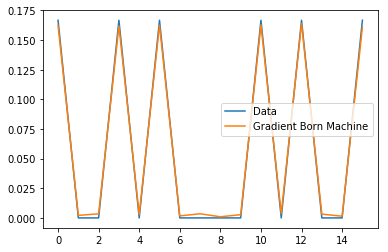

In [33]:
np.random.seed(2)
depth = 4

bm = load_barstripe((2, 2), depth)
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'L-BFGS-B', max_iter=20, popsize=10)
pl = bm.pdf(theta_list)

# display
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
plt.show()